In [88]:
%matplotlib inline

In [89]:
from vgg16 import Vgg16
from utils import plots
import matplotlib

In [3]:
path = '/mnt/data/dogscats/'
batch_size = 64

In [4]:
vgg = Vgg16()

In [6]:
batches = vgg.get_batches(path=path + 'train', batch_size=batch_size)
val_batches = vgg.get_batches(path=path + 'valid', batch_size=batch_size*2)
vgg.finetune(batches)
vgg.fit(batches, val_batches, nb_epoch=1)

Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Epoch 1/1
23000/23000 [==============================] - 818s - loss: 0.4311 - acc: 0.8713 - val_loss: 0.2142 - val_acc: 0.9180


In [19]:
imgs, labels = next(batches)

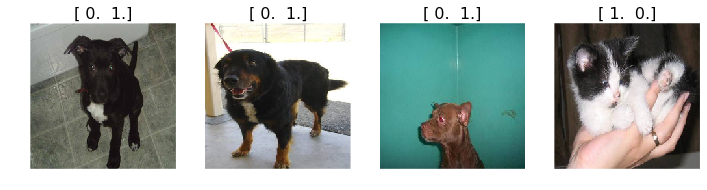

In [20]:
plots(imgs, titles=labels)

In [21]:
vgg.predict(imgs, True)

(array([ 0.1872,  0.1854,  0.3369,  0.2521], dtype=float32),
 array([195, 214, 736, 377]),
 [u'Boston_bull', u'Gordon_setter', u'pool_table', u'marmoset'])

In [23]:
vgg.classes[:4]

[u'tench', u'goldfish', u'great_white_shark', u'tiger_shark']

## Kaggle Competition

In [78]:
from vgg16 import Vgg16
from utils import plots
from utils import save_array
from utils import load_array
from keras.models import Sequential
from keras.models import load_model
import numpy as np
import pandas as pd
from keras.preprocessing import image

In [2]:
vgg = Vgg16()

## Helper Vars

In [14]:
load_model = True
load_preds = True

## Setup Paths

In [7]:
results_path = '/mnt/results/dogscats/'
model_save_path = '/mnt/models/dogscats/'
train_path = '/mnt/data/dogscats/kaggle/' + 'train/'
val_path = '/mnt/data/dogscats/kaggle/' + 'valid/'
test_path = '/mnt/data/dogscats/kaggle/' + 'test/'
batch_size = 64

## Setup batch generators

In [10]:
batches = vgg.get_batches(train_path, batch_size=batch_size)
val_batches = vgg.get_batches(val_path, batch_size=2*batch_size)
test_batches = vgg.get_batches(test_path, batch_size=2*batch_size, class_mode=None)

Found 20002 images belonging to 2 classes.
Found 4998 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.


In [11]:
vgg.finetune(batches)
if not load_model:
    vgg.fit(batches, val_batches, nb_epoch=1)

## Save Model

In [19]:
if not load_model:
    vgg.model.save_weights(model_save_path + 'ft1.h5')

## Load Model

In [13]:
vgg.model.load_weights(model_save_path + 'ft1.h5')

## Predict

In [15]:
if not load_preds:
    batches, preds = vgg.test(test_path, batch_size=2*batch_size)

## Save Predictions

In [16]:
if not load_preds:
    save_array(results_path + 'preds.dat', preds)
    save_array(results_path + 'filenames.dat', batches.filenames)

## Load Predictions

In [19]:
preds = load_array(results_path + 'preds.dat')
filenames = load_array(results_path + 'filenames.dat')

## Troubleshooting

In [57]:
batches, preds = vgg.test(val_path, batch_size=2*batch_size)

Found 4998 images belonging to 2 classes.


In [131]:
n_view = 4
labels = batches.classes
filenames = batches.filenames
df = pd.DataFrame({'label': labels, 'prob': preds[:, 1], 
                   'pred': np.round(preds[:, 1]), 'filename': filenames})
df.to_pickle(results_path + 'val_preds.pkl')

In [124]:
def plot_idx(df, titles=None):
    plots([image.load_img(val_path + rows['filename']) for index, rows in df.iterrows()], titles=titles)

### 5 random examples - Correct

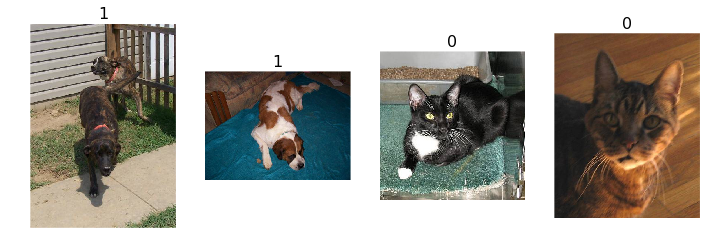

In [127]:
sel = df.loc[df.label == df.pred].sample(n_view)
plot_idx(sel, titles=list(sel.label))

## 5 random examples - incorrect

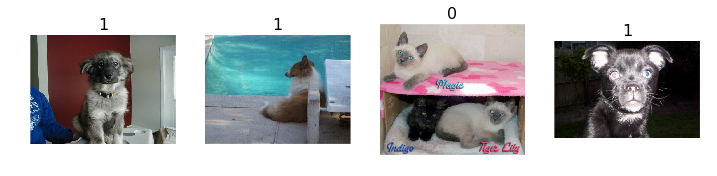

In [130]:
sel = df.loc[df.label != df.pred].sample(n_view)
plot_idx(sel, titles=list(sel.label))

## Prepare Submission

In [52]:
ids = [int(f[5:f.find('.')]) for f in filenames]
subm = np.stack([ids, preds[:, 1]], axis=1)

## Save submission

In [53]:
np.savetxt(results_path + 'subm1.csv', subm, fmt='%d,%.5f', header='id,label', comments='')